## Evaluation Metrics for Classification

In [1]:
# Common imports
import numpy as np
import os

# random seed to make output stable across runs
np.random.seed(42)

# data visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# fetch dtatset from sklearn
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X_label, y_label = mnist["data"], mnist["target"]
X_label.shape

(70000, 784)

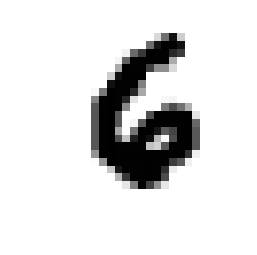

In [4]:
%matplotlib inline

digit = X_label[66043]
digit_image = digit.reshape(28, 28)
plt.imshow(digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y_label[66043] # print the label of the image above

6.0

In [6]:
# separating feature and labels for both train and test set
X_train, X_test, y_train, y_test = X_label[:60000], X_label[60000:], y_label[:60000], y_label[60000:]

In [7]:
# shuffle the training, so that there aren't many similar digist in a row 
shuffle_the_indexes = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_the_indexes], y_train[shuffle_the_indexes]

To understand the overall concept of classification better, we will start by developing and training a classiffier that classifies one digit - for example, the number 6. This classifier will be capable of distinguishing between two classes, 6 and not 6. Afterwords we will build one that classifies every digit out of the dataset.

In [8]:
# creating target vectors
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

In [9]:
# creat SGDClassifier & train it on the training set
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=None)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
# detect images of the number 6, using the "digit" variable we used above, that contains a 6.
prediction = sgd_clf.predict([digit])
print("Prediction:", prediction[0])

Prediction: True


# Evaluate Performance



Since evaluating a classifier is often harder that evaluating a regressor, we will spend a lot of time at this part of the project. Now we will use cross-validation to evaluate our current binary classifier (SGD).

K-fold cross validation splits the training set into K-folds. Afterwards it makes predictions and evuluates them on each fold using a model trained on the remaining fold.

Sometimes, you want more controll over the cross validation process, than with the pre-implemented one, that sklearn provides. Therefore I will implement cross-validation by myself, just to gain some more experience.

I will use StratifiedKFold, which performs stratified sampling to produce several folds that contain a representative ratio of each class. The cross validator creates a clone of the classifier and then trains that clone on the training folds and makes predictions on the test fold afterwards. In the end, it counts the correct predictions and gives us the performance ratio.

We will evaluate our SGDClassifier model using K-fold cross validation, with three folds.


In [11]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone
#Constructs a new estimator with the same parameters.
#Clone does a deep copy of the model in an estimator without actually copying attached data.
#It yields a new estimator with the same parameters that has not been fit on any data.

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_6):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_6[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_6[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("Accuracy:",n_correct / len(y_pred))

Accuracy: 0.9823008849557522
Accuracy: 0.98155
Accuracy: 0.9813490674533727


In [12]:
from sklearn.base import BaseEstimator
class not_a_6(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_6_clf = not_a_6()
from sklearn.model_selection import cross_val_score # out of simplicits, we just use the build in cross validator
accuracy = cross_val_score(never_6_clf, X_train, y_train_6, cv=3, scoring="accuracy")
print("Accuracy:", accuracy)

Accuracy: [0.8993  0.90115 0.90365]


Also over 90% accuracy on every fold. This is because just around 10% of the images are sixes and if you therefore always guess an image is not a 6, you will be right 90% of the time.

This is the reason why accuracy is the wrong measure for classiffiacation problems in machine learning. This is especially true, when some classes are much more frequent than others (e.g skewed dataset).

A much better measure of how good our model does, is the so called confusion matrix, which we will cover below.


To use the **confusion matrix**, we will first need predictions that can be compared to the actual target. We will use the cross_vall_predict() function, which returns the clean predictions made on each test set, instead of the evaluated scores that the cross_val_score() function returns. Clean means the prediction is made by a model, that never saw the data before.

In [14]:
# cross_val_predict()
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)

# building confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6, predictions)

array([[53459,   623],
       [  473,  5445]])

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_6, predictions)

0.8973302570863546

In [16]:
recall_score(y_train_6, predictions)

0.9200743494423792

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_6, predictions)

0.908559986651093

Now we have a much better evaluation of our classifier. Our model classifies 89% of the time images correctly as a 6. The precision tells us that it predicted 92 % of the 6s as a 6.


There we have it, a 90 % F-score.

But unfortunately the F-score isn't the holy grail and has it's tradeoffs. It favors classifiers that have similar precision and recall. This is a problem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, results in an decreasing recall and vice versa. This is called the precision/recall tradeoff and we will cover it in the next section.


In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train_6, y_scores)

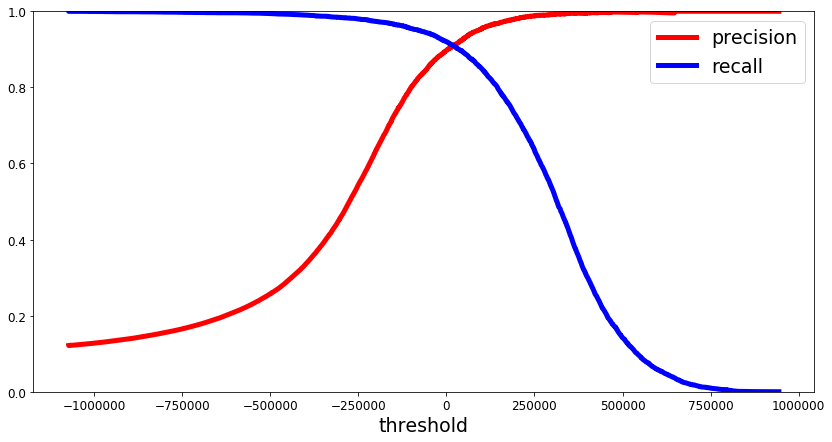

In [19]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

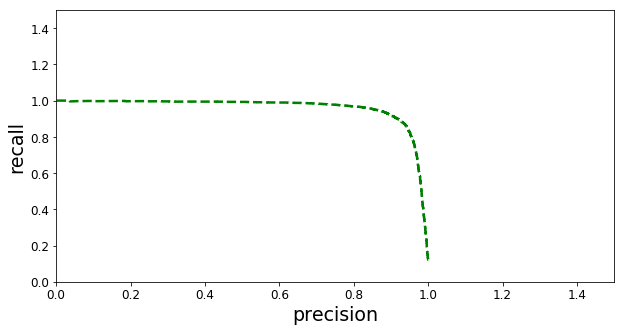

In [20]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(10, 5))
plot_precision_vs_recall(precision, recall)
plt.show()

## ROC Curve and ROC AUC Score

The ROC curve is another tool to to evaluate and compare binary classifiers. It has a lot of similarities with the precision/recall curve, although it is quite different. It plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.

To generate a ROC curve, we need to compute the true positive rate and the false positive rate for several threshold values. We can use the "roc_curve()" function for this task. Afterwards we need to plot them against each other with matplotlib

In [21]:
# compute true positive rate and false positive rate
from sklearn.metrics import roc_curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_6, y_scores)

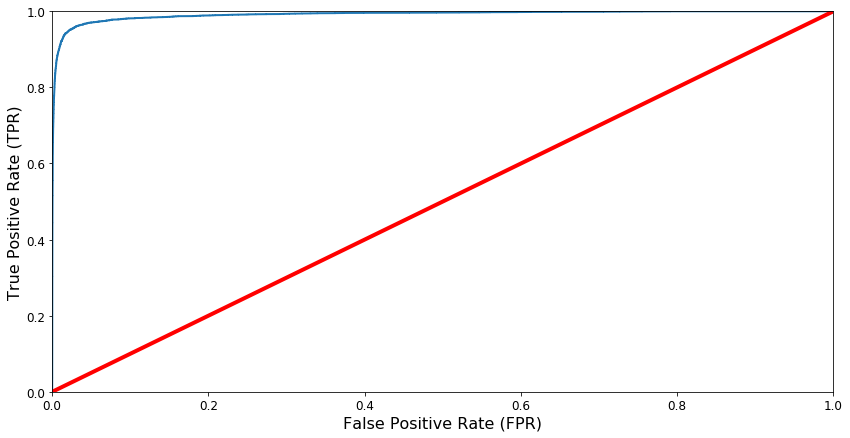

In [22]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()


In [23]:
# computing ROC AUC
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_train_6, y_scores)
print("ROC-AUC-Score:", score)

ROC-AUC-Score: 0.9914368951887224


In [24]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(random_forest, X_train, y_train_6, cv=3, method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_6, y_scores_forest)

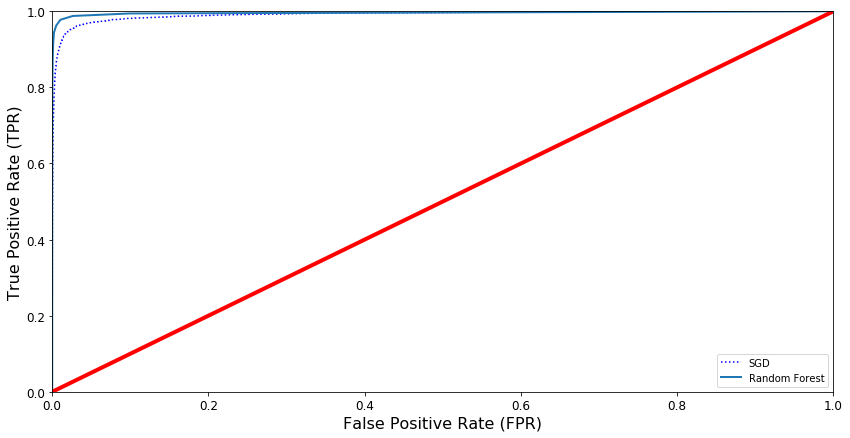

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(false_positive_rate, true_positive_rate, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")

plt.show()

In [26]:
# ROC AUC Score:
score = roc_auc_score(y_train_6, y_scores_forest)
print("ROC-AUC-Score:", score)

ROC-AUC-Score: 0.9959054781807241


In [27]:
# Precision:
y_train_pred_forest = cross_val_predict(random_forest, X_train, y_train_6, cv=3)
score = precision_score(y_train_6, y_train_pred_forest)
print("Precision:", score)

Precision: 0.9877848678213309


In [28]:
# recall:
score = recall_score(y_train_6, y_train_pred_forest)
print("Recall:", score)

Recall: 0.9155119972963839


The RandomForestsClassifiers ROC curve looks better than the one of the SGDClassifier, because it comes closer to the top left corner.

Now we definitely learned a lot of stuff. We learned how to train a binary classififer, how to to evaluate it and with which tool, how to use cross validation, how to select the right precision/recall tradeoff and how to compare different classifiers with the ROC AUC score. Now it is time to tackle multiclass classification.


## References

1. https://en.wikipedia.org/wiki/Confusion_matrix
2. https://github.com/Donges-Niklas/Classification-Basics/blob/master/Classification_Basics.ipynb
3. 
